## Ansatzと変分フォーム

すべての変分アルゴリズムの中心には、状態と状態の違いを分析するという重要なアイデアがあります。状態間の違いは、一連のパラメーターまたは変数から適切に動作するマッピング (たとえば、連続、微分可能) を通じて便利に関連付けられます。したがって、この名前が付けられました。

はじめに、パラメーター化された回路を手作業で構築する方法を探ります。この回路を使って [*変分形式*](gloss:variational) を定義し、変分アルゴリズムが探索するパラメーター化された状態の集合を定義します。そして、この変分形式を参照状態に適用することで、 [*Ansatz*](gloss:ansatz) を構築します。

また、この探索空間を探索する際に、速度と精度のトレードオフをどのように行うかを検討します。

![Ansatz Workflow](images/ansatz_workflow.png)

## パラメーター化された量子回路

変分アルゴリズムは、有限の $k$ 個のパラメーター $\vec{\theta} = (\theta^0, \ldots, \theta^{k-1})$ に依存する量子状態 $|\psi(\vec{\theta})\rangle$ を探索・比較することで動作します。これらの状態は、パラメーター化された量子回路を用いて準備することができ、そのゲートは調整可能なパラメーターで定義されています。このパラメーター化された量子回路は、特定の角度に縛られることなく作成することが可能です：

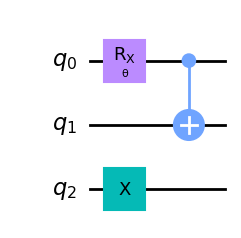

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter("θ")

qc = QuantumCircuit(3)
qc.rx(theta, 0)
qc.cx(0, 1)
qc.x(2)

qc.draw("mpl")

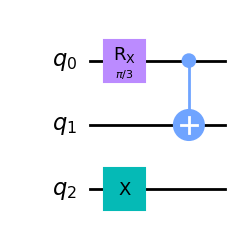

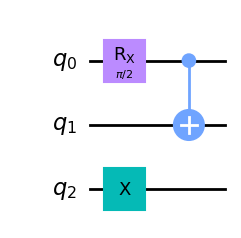

In [2]:
from math import pi

angle_list = [pi / 3, pi / 2]
circuits = [qc.bind_parameters({theta: angle}) for angle in angle_list]

for circuit in circuits:
    display(circuit.draw("mpl"))

## 変分形式とAnsatz

参照状態 $|\rho\rangle$  から目標状態 $|\psi(\vec\theta)\rangle$ へ反復最適化するために、変分アルゴリズムが探索するパラメーター化された状態の集合を表す変分形式 $U_V(\vec{\theta})$ を定義する必要があります：

$$
|0\rangle \xrightarrow{U_R} U_R|0\rangle = |\rho\rangle \xrightarrow{U_V(\vec{\theta})} U_A(\vec{\theta})|0\rangle
$$

$$ = U_V(\vec{\theta})U_R|0\rangle $$

$$ = U_V(\vec{\theta})|\rho\rangle $$

$$ = |\psi(\vec{\theta})\rangle $$

パラメーター化された状態は、パラメーターに依存しない参照状態 $|\rho\rangle$ と、常にパラメーターに依存する変分形式 $U_V(\vec{\theta})$ の両方に依存していることに注意してください。 この2つを組み合わせたもの $U_A(\vec\theta) := U_V(\vec\theta)U_R$ をansatzと呼日ます。

変分アルゴリズムが探索するパラメーター化された状態の集合を表現するために、このansatzを構築するとき、重要な問題に気づきます。次元性です。 $n$ 量子ビットのシステム（ヒルベルト空間）の構成空間には、膨大な数の量子状態が存在します。これを完全に探索するためには、扱いにくい数のパラメーターが必要になります。定量的には、その次元性は $D = 2^{2n}$ です。さらに悪いことに、探索アルゴリズムなどの実行複雑度は、この次元性によって指数関数的に増大し、文献ではしばしば次元の呪いと呼ばれている現象となります。

この欠点に対処するために、最も関連性の高い状態のみを探索するような合理的な制約を変分形式に課すことが一般的です。効率的に切り捨てられたansatzを見つける研究は盛んに行われていますが、ここでは2つの一般的なデザインを取り上げることにします。

## ヒューリスティックAnsatzとトレードオフ

次元数を制限するのに役立つ特定の問題に関する情報がない場合、 $2^{2n}$ 未満のパラメーターを持つ任意のパラメーター化された回路ファミリーを試すことができます。しかし、次のような考慮すべきトレードオフがいくつかあります：

- **速度**: 探索空間を縮小することで、アルゴリズムの実行速度を向上させることができます。
- **精度**: ただし、探索空間を小さくすると、問題の実際の解を除外してしまい、最適な解が得られない可能性があります。
- **ノイズ**: 深い回路はノイズの影響を受けるため、ansatzの接続性、ゲート、ゲートフィデリティを実験する必要があります。

品質（あるいは解きやすさ）と速度の間には基本的なトレードオフがあります：パラメーターが多ければ多いほど、正確な結果が得られる可能性が高くなりますが、アルゴリズムの実行にかかる時間は長くなってしまうのです。

### N-local 回路

ヒューリスティックansatzで最も広く使われている例の1つが [N-local回路](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits) です：

- **効率的な実装**: N-local回路は、一般的にシンプルなローカルゲートで構成されており、少数の物理量子ビットを用いて量子コンピューター上で効率的に実装することができます。これにより、量子回路の構築や最適化が容易になります。
- **重要な相関関係をとらえる**: N-local ansatzは、少ないゲート数でも量子系における量子ビット間の重要な相関を捉えることができます。これは、ローカルゲートが隣接する量子ビットに作用し、量子ビット間にエンタングルメントを生じさせることができるためで、複雑な量子系をシミュレーションする上で重要な意味を持ちます。

これらの回路は、以下のように交互に1回以上繰り返される回転層とエンタングルメント層で構成されています：

- 各層は最大 $N$ 個のゲートで形成され、 $N$ は量子ビット数より小さくなければなりません。
- 回転層では、ゲートは互いに積み重ねます。[`RX`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXGate.html) や [`CRZ`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CRZGate.html) のような標準的な回転演算を使用することができます。
- エンタングルメント層には、エンタングルメントを作る [`とフォリ` ゲート ](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CCXGate.html) や [`CX`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CXGate.html#qiskit.circuit.library.CXGate) のようなゲートを使用できます。
- どちらの層も、パラメーター化することもしないこともできますが、少なくとも1つの層はパラメーターを含む必要があります。そうでなければ、1つもパラメーターがないことになり、変化が生まれません！
- オプションとして、回路の末尾に回転層を追加することもできます。

例えば、 [`RX`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RXGate.html) ゲートと [`CRZ`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CRZGate.html) ゲートで形成される回転ブロック、量子ビット $[0,1,2]$, $[0,2,3]$, $[4,2,1]$ $[3,1,0]$ に作用する [`トフォリ` ゲート](https://qiskit.org/documentation/stubs/qiskit.circuit.library.CCXGate.html) で形成されるエンタングルメントブロックが各層2回の繰り返される $5$ 量子ビットの [`NLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.NLocal.html) 回路を作ってみましょう。

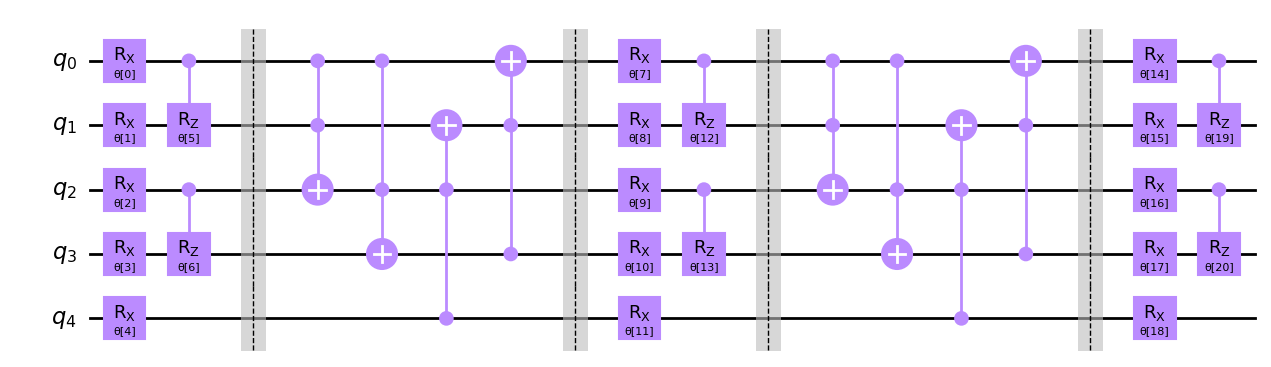

In [3]:
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate
from qiskit.circuit import Parameter

theta = Parameter("θ")
ansatz = NLocal(
    num_qubits=5,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],
    entanglement_blocks=CCXGate(),
    entanglement=[[0, 1, 2], [0, 2, 3], [4, 2, 1], [3, 1, 0]],
    reps=2,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

In the above example, the largest gate 上記の例では、最大のゲートは 三量子ビットに作用するトフォリゲートであり、この回路は $3$ local となります。最もよく使われるタイプの $N$ -local回路は、1量子ビット回転ゲートと $2$ 量子ビットエンタングルゲートを持つ [$2$-local]((https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html))  回路です。

Qiskitの [`TwoLocal`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html)  クラスを使って、$2$ -local回路を作成してみましょう。構文は `NLocal` と同じですが、いくつかの相違点があります。例えば、 `RX`, `RZ`, `CNOT`, `RZ`, and `CNOT`などのほとんどのゲートは、ゲートをインポートしたり `Parameter` インスタンスを作成したりせずに、文字列として渡すことができます。

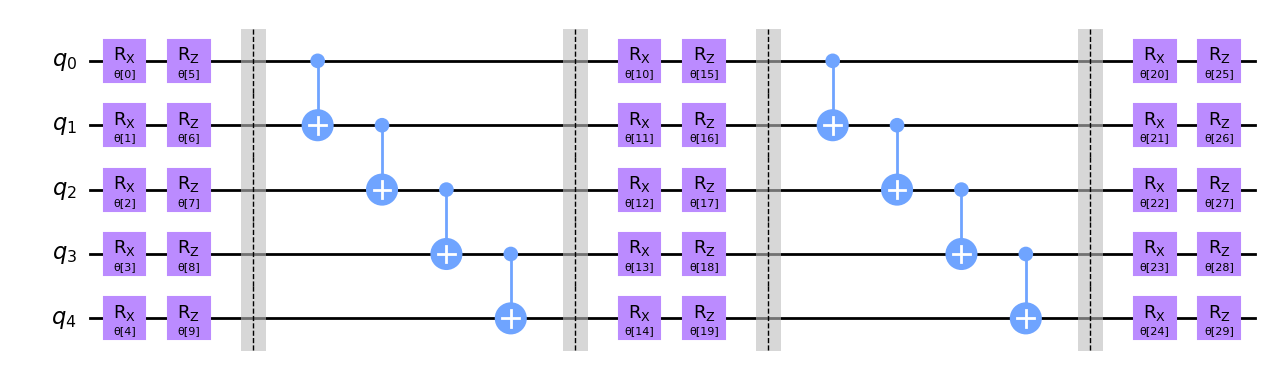

In [4]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(
    num_qubits=5,
    rotation_blocks=["rx", "rz"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=2,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

ここでは、各量子ビットが次の量子ビットとエンタングルする、線形エンタングルメント分布を使用しました。他の戦略については、[`TwoLocal` のドキュメント](https://qiskit.org/documentation/stubs/qiskit.circuit.library.TwoLocal.html) を参照してください。

### EfficientSU2

[`EfficientSU2`](https://qiskit.org/documentation/stubs/qiskit.circuit.library.EfficientSU2.html) は、SU(2)にまたがる1量子ビット演算の層と `CX` エンタングルメントのそうで構成されるハードウェアに対して効率の高い回路です。変分量子アルゴリズムの試行波動関数の準備や、機械学習の分類回路として利用できるヒューリスティックなパターンです。

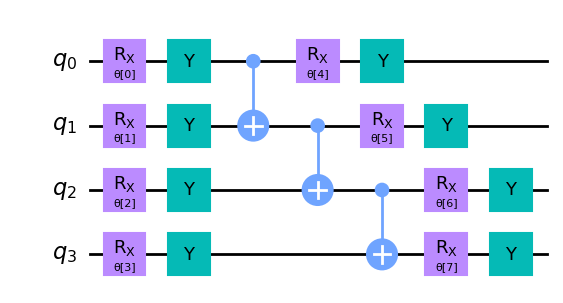

In [5]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(4, su2_gates=["rx", "y"], entanglement="linear", reps=1)
ansatz.decompose().draw("mpl")

## 問題固有のansatze

ヒューリスティックな方法とハードウェア効率の良いansatzeは、素朴な方法で問題を解決するのに役立つ一方、問題固有の知識を使用して、回路の検索空間を特定のタイプに制限することもできます。これにより、検索プロセスの精度を落とすことなく、速度を上げることができるようになります。

### 量子化学

化学分野での典型的なアプリケーションは、特定の分子系の基底状態を求めることです。 [*Unitary Coupled-Cluster (UCC)*](https://qiskit.org/ecosystem/nature/stubs/qiskit_nature.second_q.circuit.library.UCC.html)  ansatzは当初、基底状態の探索に変分境界を追加し、探索空間の探索速度を向上させるために提案されました。以下の例では、Hartree-Fock近似を参照状態として使用し、Hartree-Fock基底状態からの二重励起でUnitary Coupled-Clusterを使用する例を示します。

/opt/conda/lib/python3.10/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


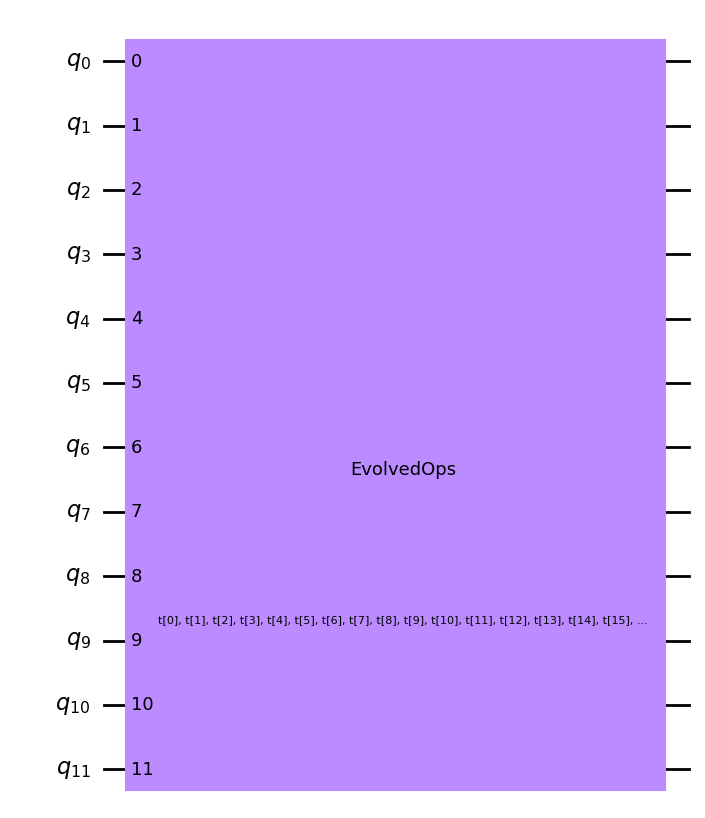

In [6]:
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import HartreeFock, UCC
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo

molecule = MoleculeInfo(
    # Coordinates in Angstrom
    symbols=["Li", "H"],
    coords=([0.0, 0.0, 0.0], [0.2, 0.0, 0.0]),
    multiplicity=1,  # = 2*spin + 1
    charge=0,
)

driver = PySCFDriver.from_molecule(molecule)
LiH_problem = driver.run()

mapper = JordanWignerMapper()
LiH_reference_state = HartreeFock(
    num_spatial_orbitals=LiH_problem.num_spatial_orbitals,
    num_particles=LiH_problem.num_particles,
    qubit_mapper=mapper,
)

ansatz = UCC(
    num_spatial_orbitals=LiH_problem.num_spatial_orbitals,
    num_particles=LiH_problem.num_particles,
    qubit_mapper=mapper,
    initial_state=LiH_reference_state,
    excitations=2,
)

ansatz.draw("mpl")

### 量子機械学習

機械学習で一般的なアプリケーションは、データを2つ以上のカテゴリーに [分類](https://learn.qiskit.org/course/machine-learning/variational-classification) することです。この場合、古典的な特徴量ベクトルを量子ヒルベルト空間にマッピングする特徴量マップに [データ点を符号化](https://learn.qiskit.org/course/machine-learning/data-encoding) する必要があります。古典的なシミュレーションが困難なパラメーター化された量子回路に基づいて量子特徴量マップを構築することは、古典的な機械学習アプローチに対する潜在的な優位性を得るための重要なステップであり、現在活発に研究が行われている分野です。

[ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html) は、パラメーター化された回路を作成するために使用することができます。特徴量マップ( $x$ )と重みをパラメーターとして渡すための別の変分形式( $\theta$ )にデータ点を渡します。

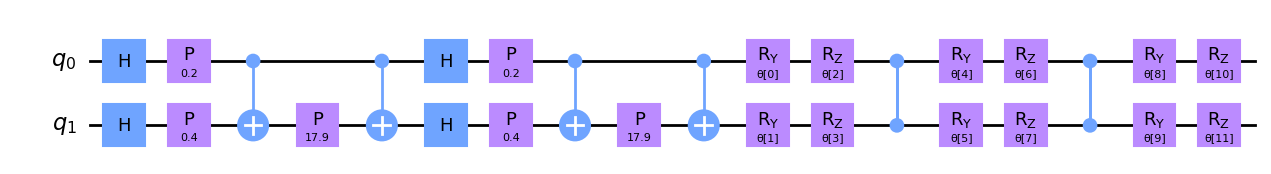

In [7]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

data = [0.1, 0.2]

zz_feature_map_reference = ZZFeatureMap(feature_dimension=2, reps=2)
zz_feature_map_reference = zz_feature_map_reference.bind_parameters(data)

variation_form = TwoLocal(2, ["ry", "rz"], "cz", reps=2)
vqc_ansatz = zz_feature_map_reference.compose(variation_form)
vqc_ansatz.decompose().draw("mpl")

このレッスンでは、変分形式を使って探索空間を定義する方法を学びました：

- ゲートが調整可能なパラメータで定義された、 *パラメーター化された* 量子回路で状態を準備します。
- 速度と精度をトレードオフするansatzeの組み立て方
- ヒューリスティックなansatze
- 問題に固有のansatze

このハイレベルな変分の作業は次のようになります：

![Ansatz Circuit](images/ansatz_circuit.png)

各変形パラメーター $\vec\theta$ に対して、異なる量子状態が生成されます。最適なパラメーターを見つけるために、問題に応じた *コスト関数* を定義して、ansatzのパラメーターを繰り返し更新する必要があります。